<a href="https://colab.research.google.com/github/pierredumontel/plane-classification/blob/main/notebooks/train_classification_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Données tabulaires (reg logisitique -> pas approprié pour vecteur de coordonnées d'images) 
Pytorch (Facebook) vs tensorflow (Google) (pour les NN complexes)

Pytorch + facile a utilisé en termes de structure de réseaux

Keras : sur couche des 2 autres 

pep8 

In [7]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar zxf fgvc-aircraft-2013b.tar.gz
!mv fgvc-aircraft-2013b/ dataset 

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  28.1M      0  0:01:33  0:01:33 --:--:-- 27.9M


In [35]:
import keras

In [36]:
keras.__version__

'2.8.0'

# Imports

In [52]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 

import tensorflow as tf

from sklearn.model_selection import train_test_split

#from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from PIL import Image

In [3]:
pd.__version__

'1.3.5'

In [9]:
DATA_DIR = pathlib.Path('dataset/data')

### Make assumptions about number of spaces (here=2)

In [ ]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt',sep=' ',
            names=['image_id','m1','m2'],
            usecols=['image_id','m1','m2'],#usecols for v1.4 compatibility
            dtype={'image_id':str}) #ids are not int but string 
manufacturer_df['manufacturer']=manufacturer_df['m1']+' '+manufacturer_df['m2']
manufacturer_df['manufacturer'].unique()

array([nan, 'British Aerospace', 'Lockheed Corporation',
       'Douglas Aircraft', 'McDonnell Douglas', 'de Havilland',
       'Lockheed Martin', 'Dassault Aviation', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Cirrus Aircraft'], dtype=object)

In [ ]:
! grep ',' dataset/data/images_manufacturer_train.txt

In [ ]:
#Recherche le caractère T dans le fichier et n'affiche que trois lignes (head -3)
! grep 'T' dataset/data/images_manufacturer_train.txt | head -3

0724121 ATR
0619697 ATR
2243949 ATR


In [ ]:
#wc : Compte le nombre d'élements (-l : ligne, -c : caractère, -w : word)
! grep 'T' dataset/data/images_manufacturer_train.txt | wc 

    132     264    1848


In [ ]:
!cut -f 1 -d' ' dataset/data/images_manufacturer_train.txt | head

1025794
1340192
0056978
0698580
0450014
1042824
0894380
1427680
0817494
0716386


In [ ]:
manufacturer_df = pd.read_csv(DATA_DIR / 'images_manufacturer_train.txt',sep='\t',
            names=['all'],
            dtype={'all':str}) #ids are not int but string 


#La fonction split() découpe sur une chaîne de caractères 
manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x:x.split(' ')[0])  

#La fonction '<car>'.join(liste) concatène les éléments de liste en utillisant le séparateur <car>
manufacturer_df['manufacturer']=manufacturer_df['all'].apply(lambda x:' '.join(x.split(' ')[1:])) 
manufacturer_df['manufacturer'].unique()

array(['Boeing', 'Airbus', 'ATR', 'Antonov', 'British Aerospace',
       'Beechcraft', 'Lockheed Corporation', 'Douglas Aircraft Company',
       'Canadair', 'Cessna', 'McDonnell Douglas', 'de Havilland', 'Robin',
       'Dornier', 'Embraer', 'Eurofighter', 'Lockheed Martin',
       'Dassault Aviation', 'Fokker', 'Bombardier Aerospace',
       'Gulfstream Aerospace', 'Ilyushin', 'Fairchild', 'Piper',
       'Cirrus Aircraft', 'Saab', 'Supermarine', 'Panavia', 'Tupolev',
       'Yakovlev'], dtype=object)

Verify data 

In [ ]:
manufacturer_df['manufacturer'].value_counts(dropna=False)

Boeing                      733
Airbus                      434
Embraer                     233
McDonnell Douglas           232
de Havilland                167
Canadair                    134
Douglas Aircraft Company    133
Cessna                      133
British Aerospace           133
Fokker                      100
Lockheed Corporation         68
Beechcraft                   67
Saab                         67
Gulfstream Aerospace         67
Dassault Aviation            67
Tupolev                      66
ATR                          66
Panavia                      34
Yakovlev                     34
Lockheed Martin              34
Dornier                      34
Antonov                      34
Bombardier Aerospace         33
Ilyushin                     33
Fairchild                    33
Piper                        33
Cirrus Aircraft              33
Supermarine                  33
Robin                        33
Eurofighter                  33
Name: manufacturer, dtype: int64

Verify missing data

In [ ]:
manufacturer_df.isna().sum()

all             0
image_id        0
manufacturer    0
dtype: int64

In [ ]:
assert manufacturer_df['image_id'].isna().sum()==0,"Missing value in image_id"
assert manufacturer_df['manufacturer'].isna().sum()==0,"Missing value in manufacturer"

In [ ]:
manufacturer_df.head()

,all,image_id,manufacturer
0,1025794 Boeing,1025794,Boeing
1,1340192 Boeing,1340192,Boeing
2,0056978 Boeing,0056978,Boeing
3,0698580 Boeing,0698580,Boeing
4,0450014 Boeing,0450014,Boeing


In [ ]:
manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

In [ ]:
manufacturer_df.head()

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg


In [ ]:
def build_image_database(path):
  """Build a pandas dataframe with target class and access path to images. 
  
  Parameters 
  ----------
  path (Path) : path pattern to read csv file containing images information.
  
  Returns 
  -------
  pandas dataframe, including target class and path to image. 

  """
  manufacturer_df = pd.read_csv(path,sep='\t',
            names=['all'],
            dtype={'all':str}) #ids are not int but string 


  #La fonction split() découpe sur une chaîne de caractères 
  manufacturer_df['image_id'] = manufacturer_df['all'].apply(lambda x:x.split(' ')[0])  

  #La fonction '<car>'.join(liste) concatène les éléments de liste en utillisant le séparateur <car>
  manufacturer_df['manufacturer']=manufacturer_df['all'].apply(lambda x:' '.join(x.split(' ')[1:])) 

  #La colonne path contient le chemin d'accès à l'image
  manufacturer_df['path'] = manufacturer_df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  return manufacturer_df

In [ ]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt')

,all,image_id,manufacturer,path
0,1025794 Boeing,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192 Boeing,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978 Boeing,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580 Boeing,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014 Boeing,0450014,Boeing,dataset/data/images/0450014.jpg
...,...,...,...,...
3329,1577680 Yakovlev,1577680,Yakovlev,dataset/data/images/1577680.jpg
3330,1826676 Yakovlev,1826676,Yakovlev,dataset/data/images/1826676.jpg
3331,0472681 Yakovlev,0472681,Yakovlev,dataset/data/images/0472681.jpg
3332,1597829 Yakovlev,1597829,Yakovlev,dataset/data/images/1597829.jpg


In [ ]:
# mieux que rien 
def prt():
  """ je fais ceci dans ma fonction
  """
  return 

In [ ]:
def build_image_database(path,target):
  """Build a pandas dataframe with target class and access path to images. 
  
  Parameters 
  ----------
  path (Path) : path pattern to read csv file containing images information.
  target (str) : name of the target column 
  Returns 
  -------
  pandas dataframe, including target class and path to image. 

  """
  _df = pd.read_csv(path,sep='\t',
            names=['all'],
            dtype={'all':str}
            ) #ids are not int but string 

  #La fonction split() découpe sur une chaîne de caractères 
  _df['image_id'] = _df['all'].apply(lambda x:x.split(' ')[0])  

  #La fonction '<car>'.join(liste) concatène les éléments de liste en utillisant le séparateur <car>
  _df[target]= _df['all'].apply(lambda x:' '.join(x.split(' ')[1:])) 

  #La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x + '.jpg'))

  return _df.drop(columns=['all'])

In [ ]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt','manufacturer').head(2)

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [ ]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt','family').head(2)

,image_id,family,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [ ]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt','variant').head(2)

,image_id,variant,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


In [13]:
def build_image_database(path, target) :
  """Build a pandas dataframe with target class and access path to images.

  Parameters
  ----------
  path (Path) : path pattern to read csv file containing images information. 
  target (str) : name of the target column.

  Returns 
  -------
  A pandas dataframe, including target class and path to image.
  """

  _df =pd.read_csv(path, sep='\t'
                , names=['all']
                , dtype ={'all':str} # id are string not int
                )

  #split donne une chaine de caractères
  _df['image_id'] = _df['all'].apply(lambda x: x.split(' ')[0])

  #'<car>'.join(liste) concatène les éléments de la liste avec le séparateur '<car>'
  _df[target] = _df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  # La colonne path contient le chemin d'accès à l'image
  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x +'.jpg'))

  return _df.drop(columns=['all'])

In [11]:
build_image_database(DATA_DIR / 'images_manufacturer_train.txt','variant').head(2)

,image_id,variant,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg


baselib : module qui viennent systématiquement avec Python, 

import os 
import pathlib 
import datetime 

In [14]:
manufacturer_df = build_image_database(DATA_DIR / 'images_manufacturer_train.txt','manufacturer')
manufacturer_df.head()

,image_id,manufacturer,path
0,1025794,Boeing,dataset/data/images/1025794.jpg
1,1340192,Boeing,dataset/data/images/1340192.jpg
2,0056978,Boeing,dataset/data/images/0056978.jpg
3,0698580,Boeing,dataset/data/images/0698580.jpg
4,0450014,Boeing,dataset/data/images/0450014.jpg


In [ ]:
#On récupère un chemin d'accès 
manufacturer_df.head(1)['path'].values[0]

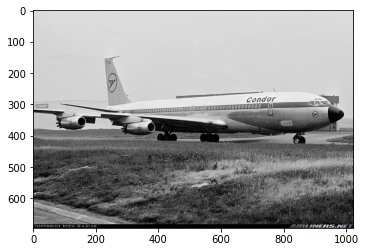

In [15]:
plt.imshow(plt.imread(manufacturer_df.head(1)['path'].values[0]))

In [30]:
#La fonction : 
# -prend un df (argument)
# -prend une ligne (row : argument)
# -prend une colonne (target : argument)
# -elle affiche la classe (la valeur de target) et l'image associée, pour la ligne en argument 

def show_image(df,row, target):
  """Show an image from an image database, with the associated class. 

  Parameters 
  ----------
  df (pd.DataFrame) : images definition dataframe
  row (int) : row index in df of image to be displayed 
  target (str) :name of the target column 

  Returns 
  -------
  None
  """
  assert target in df.columns, "Missing target columns in dataframe"
  assert 'path' in df.columns, 'Missing image path in dataframe'
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  return

Boeing


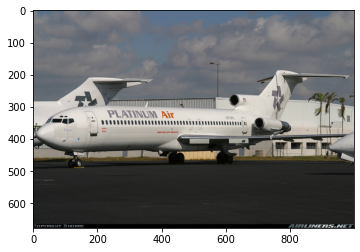

In [32]:
show_image(manufacturer_df,42,'manufacturer')

Boeing


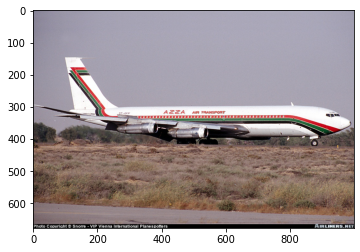

In [33]:
show_image(build_image_database(DATA_DIR / 'images_manufacturer_train.txt','manufacturer'),12,'manufacturer')

In [38]:
manufacturer_df.shape

(3334, 3)

In [40]:
plt.imread(manufacturer_df.head(1)['path'].values[0])

array([[[219, 219, 219],
        [218, 218, 218],
        [219, 219, 219],
        ...,
        [223, 223, 223],
        [222, 222, 222],
        [220, 220, 220]],

       [[217, 217, 217],
        [220, 220, 220],
        [222, 222, 222],
        ...,
        [219, 219, 219],
        [220, 220, 220],
        [222, 222, 222]],

       [[217, 217, 217],
        [221, 221, 221],
        [222, 222, 222],
        ...,
        [221, 221, 221],
        [223, 223, 223],
        [224, 224, 224]],

       ...,

       [[  0,   9,   8],
        [ 58,  70,  82],
        [101, 115, 128],
        ...,
        [  3,   1,   2],
        [  1,   0,   0],
        [  2,   0,   1]],

       [[  0,   2,   0],
        [  1,   2,   4],
        [  0,   2,   1],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  1,   1,   1]],

       [[  4,   0,   1],
        [  4,   0,   4],
        [  6,   0,   4],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

In [42]:
manufacturer_df.head(10)['path'].apply(lambda p: plt.imread(p).shape)

0    (695, 1024, 3)
1    (699, 1024, 3)
2     (687, 913, 3)
3    (678, 1000, 3)
4    (911, 1280, 3)
5    (702, 1024, 3)
6    (679, 1000, 3)
7    (718, 1024, 3)
8    (682, 1005, 3)
9    (678, 1000, 3)
Name: path, dtype: object

In [43]:
manufacturer_df['image_shape'] = manufacturer_df['path'].apply(lambda p:plt.imread(p).shape)

In [50]:
manufacturer_df['image_shape'].apply(lambda x:x[1]).value_counts()

1024    1399
1200     618
1000     492
1600     145
1050     105
        ... 
1375       1
993        1
941        1
1013       1
995        1
Name: image_shape, Length: 73, dtype: int64

In [55]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = IMAGE_WIDTH

In [56]:
images_list = []
def load_resize_image(path,width, height):
  """Load an image and resize it to the target size
  
  Parameters 
  ----------

  path (Path):access path to image file
  height (int):resize image to this height 
  width (int):resize image to this width 

  Returns
  -------
  np.array containing resized image
  
  """
  return np.array(Image.open(path).resize((width, height)))


In [58]:
manufacturer_df['resized_image'] = manufacturer_df.apply(lambda r: load_resize_image(r['path'], IMAGE_WIDTH, IMAGE_HEIGHT), axis=1)

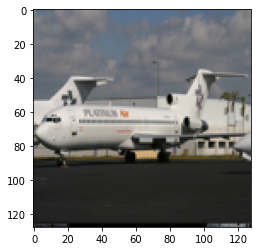

In [61]:
plt.imshow(manufacturer_df.iloc[42,]['resized_image'])

In [48]:
#Building the model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=manufacturer_df.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

#Compilation of the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

ValueError: ignored